In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pathlib
from scipy.io import loadmat
import pandas as pd
import pywt
from scipy.signal import find_peaks,peak_widths
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#cut all the QRS wave and use to classify


In [3]:
data = 'ECG3'
data_dir = pathlib.Path(data)
data_dir

WindowsPath('ECG3')

In [4]:
data_dict = {
    '1 NSR': list(data_dir.glob('1 NSR/*')),
    '4 AFIB': list(data_dir.glob('4 AFIB/*')),
}

In [5]:
data_lavel_dict = {
    '1 NSR': 0,
    '4 AFIB': 1,
}

In [6]:
data_dict['1 NSR'][64]

WindowsPath('ECG3/1 NSR/108m (1).mat')

In [7]:
dataset = []
y = []
for lavel, datas in data_dict.items():
    for sig in datas:
        data = loadmat(str(sig))
        Data=data['val'][0]
        dataset.append(Data)
        y.append(data_lavel_dict[lavel])
        

In [8]:
dataset

[array([953, 951, 949, ..., 940, 943, 944], dtype=int16),
 array([915, 927, 934, ..., 965, 963, 962], dtype=int16),
 array([989, 984, 981, ..., 949, 949, 952], dtype=int16),
 array([957, 961, 961, ..., 948, 953, 952], dtype=int16),
 array([942, 943, 943, ..., 986, 986, 987], dtype=int16),
 array([ 945,  948,  945, ..., 1028,  956,  919], dtype=int16),
 array([964, 965, 966, ..., 952, 954, 953], dtype=int16),
 array([967, 974, 971, ..., 960, 959, 958], dtype=int16),
 array([951, 952, 954, ..., 971, 969, 966], dtype=int16),
 array([958, 960, 962, ..., 975, 978, 978], dtype=int16),
 array([970, 970, 972, ..., 961, 960, 959], dtype=int16),
 array([952, 954, 957, ..., 930, 931, 929], dtype=int16),
 array([ 937,  941,  943, ..., 1062, 1051, 1041], dtype=int16),
 array([927, 926, 928, ..., 946, 945, 947], dtype=int16),
 array([943, 937, 934, ..., 971, 973, 971], dtype=int16),
 array([961, 961, 962, ..., 975, 973, 973], dtype=int16),
 array([977, 980, 981, ..., 982, 981, 979], dtype=int16),
 a

In [9]:
def feature_extractor(sample_frequency,x):
    #sample_frequency = 360
    fs = sample_frequency
    t = np.arange(0,len(x))
    tx = t/fs

    #signal filtration and possible Peak detection
    coeffs1 = pywt.wavedec(x,'sym4',level = 4,mode= 'periodic')
    z0 = np.zeros(len(coeffs1[0]))
    z1 = np.zeros(len(coeffs1[2]))
    z3 = np.zeros(len(coeffs1[3]))
    z4 = np.zeros(len(coeffs1[4]))

    coeffs1[3] = z3
    coeffs1[4] = z4

    y1 = pywt.waverec(coeffs1,'sym4',mode = 'periodic')

    avg1 = np.mean(abs(y1))

    peaks1 = find_peaks(y1,height=avg1,distance = 200)

    nop1 = peaks1[0]
    posi1 = peaks1[1]
    posi1 = posi1['peak_heights']

    #applying wavelet transform
    coeffs = pywt.wavedec(y1,'sym4',level = 4,mode = 'periodic')

    #Removing some part of coefficient for proper R peak detection purpose
    z1 = np.zeros(len(coeffs[0]))
    z3 = np.zeros(len(coeffs[3]))
    z4 = np.zeros(len(coeffs[4]))
    coeffs[0] = z1
    coeffs[3] = z3
    coeffs[4] = z4

    #reconstracting the signal
    y = pywt.waverec(coeffs,'sym4',mode = 'periodic')

    #finding the R_peaks from the reconstracted signal
    avg = np.mean(abs(y))
    peaks = find_peaks(y,height = avg*3,distance = 50)

    nop = peaks[0]
    posi = peaks[1]
    posi = posi['peak_heights']
    number_Rpeak = len(nop)

    #Finding Number of beats per minute or Heartbeat
    nump = len(nop)
    time = len(x)/fs
    nob = (nump*60)/time

    #Original R peak and height
    new_nop = []
    for i in nop1:
        for j in nop:
            if abs(i-j)< 15:
                new_nop.append(i)
                continue
            else:
                pass

    r_real_height = []
    for i in new_nop:
        r_real_height.append(y1[i])

    #finding height of R-peaks
    avg_height = round(np.mean(r_real_height),2)
    minimum_height = round(min(r_real_height),2)
    maximum_height = round(max(r_real_height),2)

    #finding peak width
    results_half = peak_widths(y1, new_nop, rel_height=0.5)
    width = results_half[0]

    avrg_width = round(np.mean(width),2)
    maximum_width = round(max(width),2)
    minimum_width = round(min(width),2)

    #finding R-R peak Distance
    new_nop = np.array(new_nop)
    nop_s = new_nop/fs
    peak_dis = []

    for i in range(len(nop_s)-1):
        dis = abs(nop_s[i]-nop_s[i+1])
        dis = round(dis,1)
        peak_dis.append(dis)

    avr_distance = round(np.mean(peak_dis),2)
    max_distance = round(max(peak_dis),2)
    min_distance = round(min(peak_dis),2)

    #finding discontinuty
    disc = []
    for i in range(len(peak_dis)):
        if 0.6 <= peak_dis[i] <= 1.2:
            disc.append(0)
        else:
            disc.append(1)

    if max(disc) == 1:
        discontinuty = 1
    else:
        discontinuty = 0

    #P-peaks detection
    peaks_for_p = find_peaks(y1,height= 0*avg1,distance = 20)
    nop_for_p = peaks_for_p[0]
    posi_for_p = peaks_for_p[1]
    posi_for_p = posi_for_p['peak_heights']

    p_peaks = []
    p_height = []
    p_R_dis = []
    nopp = new_nop

    #def p_detection(p_value):

    for i,n in enumerate(nopp):
        #print('n = ',n)
        #print('i = ',i)
        for j,m in enumerate(nop_for_p):
            #print('m = ',m)

            if m == n:
                #print('found equal')

                if (j-1) < 0:
                    k=j
                elif (j-1) == 0:
                    k = j-1
                else:
                    k = j-1
                #print('not zero')
                l = nop_for_p[k]
                #print('l = ',l)


                if (i-1) < 0:
                    p=i
                elif (i-1) == 0:
                    p = i-1
                else:
                    p = i-1
                #print('p = ',p)

                for qw in range(10):
                    if l != nopp[p]:
                        #print(n-l)

                        if (fs*0.12)-3 < n-l < (fs*0.20)+5:
                            p_peaks.append(l)
                            p_height.append(posi_for_p[k])
                            p_R_dis.append(abs(n-l))
                            break
                        else:
                            k = k-1
                            l = nop_for_p[k]

                    else:
                        pass


            else:
                pass

    #finding Height of p_peaks
    number_ppeaks = len(p_peaks)
    max_height = round(max(p_height),2)
    min_height = round(min(p_height),2)
    avg_pheight = round(np.mean(p_height),2)

    #P-R Interval or Distance
    p_R_dis = np.array(p_R_dis)/fs
    max_PR_dis = round(max(p_R_dis),2)
    min_PR_dist = round(min(p_R_dis),2)
    avg_PR_dis = round(np.mean(p_R_dis),2)

    #QRS interval detection
    r_y = -1*y1
    avg2 = np.mean(abs(r_y))
    QRS_peaks = find_peaks(r_y,height = -1*avg2*2,distance = 5)
    QRS_nop1 = QRS_peaks[0]
    QRS_posi = QRS_peaks[1]
    QRS_posi = QRS_posi['peak_heights']

    QRS_nop = np.append (QRS_nop1, new_nop)
    QRS_nop.sort()

    #QRS interval detection
    Q_peaks = []
    Q_hei = []
    Q_dis = []
    s_peaks = []
    s_hei = []
    s_dis = []
    nopp = new_nop

    for i,n in enumerate(nopp):
        #print('n = ',n)
        #print('i = ',i)
        for j,m in enumerate(QRS_nop):
            #print('m = ',m)

            if m == n:
                #print('found equal')

                if (j-1) < 0:
                    k=j
                elif (j-1) == 0:
                    k = j-1

                else:
                    k = j-1
                #for s peak
                if j+1 > len(QRS_nop):
                    e = j
                elif j+1 == len(QRS_nop):
                    e = j
                else:
                    e = j+1

                #print('not zero')
                l = QRS_nop[k]
                #print('l = ',l)
                s = QRS_nop[e]


                if (i-1) < 0:
                    p=i
                elif (i-1) == 0:
                    p = i-1
                else:
                    p = i-1

                #for s peak
                if i+1 > len(nopp):
                    g = i
                elif i+1 == len(nopp):
                    g = i
                else:
                    g = i+1
                #print('p = ',p)  
                if l != nopp[p]:
                    #print(n-l)

                    if n-l < 25:
                        #print("p R =",l,m)
                        Q_peaks.append(l)
                        Q_hei.append(y1[l])

                    else:
                        Q_peaks.append(n-8)
                        Q_hei.append(0)
                else:
                    Q_peaks.append(n-8)
                    Q_hei.append(0)

                if s != nopp[g]:

                    if abs(n-s) < 25:
                        #print("p R =",l,m)
                        s_peaks.append(s)
                        s_hei.append(y1[s])


                    else:
                        s_peaks.append(n+12)
                        s_hei.append(0)
                else:
                    s_peaks.append(n+12)
                    s_hei.append(0)
            else:
                pass

    q_peaks1 = np.array(Q_peaks)
    S_peaks1 =np.array(s_peaks)
    QRS_intervel = abs(S_peaks1 - q_peaks1 )

    #finding Height of p_peaks
    '''
    s_hei
    Q_hei
    '''
    avg_hei_s = round(np.mean(s_hei))
    avg_hei_q = round(np.mean(Q_hei))

    #QRS Interval or Distance
    QRS_intervel = (QRS_intervel)/fs
    max_QRS_dis = round(max(QRS_intervel),2)
    min_QRS_dist = round(min(QRS_intervel),2)
    avg_QRS_dis = round(np.mean(QRS_intervel),2)

    #feature list
    feature = [nob,maximum_height,minimum_height,avg_height,maximum_width,minimum_width,avrg_width,max_distance,min_distance,avr_distance,discontinuty,number_Rpeak,number_ppeaks,max_height,min_height,avg_pheight,max_PR_dis,min_PR_dist,avg_PR_dis,max_QRS_dis,min_QRS_dist,avg_QRS_dis,abs(avg_hei_s),abs(avg_hei_q)]
    return(feature)
    #feature = [nob,maximum_height,minimum_height,avg_height,maximum_width,minimum_width,avrg_width,max_distance,min_distance,avr_distance,discontinuty,max_height,min_height,avg_pheight,max_PR_dis,min_PR_dist,avg_PR_dis,max_QRS_dis,min_QRS_dist,avg_QRS_dis]
    #return(feature)

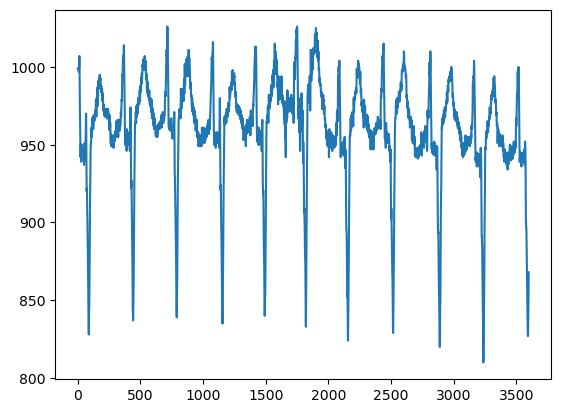

In [10]:
plt.plot(dataset[64])

In [11]:
x = []
for i in range(len(dataset)):
    f = feature_extractor(360,dataset[i])
    #f = f[1:11]
    #al = np.array(al)
    #f.append(al)
    #f = np.array(f)
    x.append(f)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
#plt.plot(x[2][7])

In [13]:
x[2]

[84.0,
 1249.57,
 1167.64,
 1217.82,
 8.61,
 5.83,
 7.51,
 0.8,
 0.7,
 0.72,
 0,
 14,
 14,
 1012.49,
 980.76,
 996.97,
 0.19,
 0.12,
 0.15,
 0.06,
 0.02,
 0.05,
 916,
 936]

In [14]:
len(x[5])

24

In [15]:
len(x)

411

In [16]:
x = np.array(x)
y = np.array(y)

In [17]:
x.shape

(411, 24)

In [19]:
from sklearn.preprocessing import StandardScaler
stnd = StandardScaler().fit(x)

In [20]:
x = stnd.transform(x)

In [21]:
x

array([[ 0.03771361, -0.23549624, -0.12838737, ..., -1.18861738,
         0.67254773,  0.51743247],
       [-0.30673735, -0.34663655, -0.17229403, ..., -1.18861738,
         0.65636943,  0.4895682 ],
       [ 0.38216456, -0.37955897, -0.34164829, ..., -1.18861738,
         0.62940559,  0.60102527],
       ...,
       [ 0.03771361,  0.12078949,  0.38889039, ..., -0.43819996,
         0.88825846, -0.57391806],
       [ 0.03771361,  0.26427337, -0.087191  , ...,  0.31221747,
         0.99072105,  0.5313646 ],
       [ 0.38216456,  0.13222189, -0.75578025, ...,  0.31221747,
         0.83433078,  0.54529674]])

In [22]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=0)

In [24]:
x_test.shape

(83, 24)

In [25]:
y_train.shape

(328,)

In [26]:
num_classes = 2
model1 = Sequential([
    #layers.Normalization(axis=None),
    layers.Dense(24,activation = 'relu'),
    layers.Dense(15,activation = 'relu'),
    layers.Dense(10,activation = 'relu'),
    layers.Dense(10,activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
    
])

model1.compile(optimizer = 'adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True
            ),
             metrics = ['accuracy'])


In [27]:
history = model1.fit(x_train, y_train, epochs = 100)

Epoch 1/100


C:\Users\user\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 1s 3ms/step - loss: 0.7144 - accuracy: 0.5335
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6220
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.5542 - accuracy: 0.7073
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.4854 - accuracy: 0.7287
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.7927
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3725 - accuracy: 0.8293
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3274 - accuracy: 0.8659
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.9177
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2532 - accuracy: 0.9360
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 0.9482
Epoch 11/100
11/11 [=

In [28]:
model1.evaluate(x_test,y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.9759


[0.29558226466178894, 0.9759036302566528]

In [29]:
predicted = model1.predict(x_test)

3/3 [==============================] - 0s 2ms/step


In [30]:
predicted1 = np.round(predicted)

In [31]:
predicted2 = []
for i in range(len(predicted1)):
    z = np.argmax(predicted1[i])
    predicted2.append(z)

In [32]:
from sklearn.metrics import confusion_matrix , classification_report

In [33]:
print(classification_report(y_test,predicted2))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        52
           1       1.00      0.90      0.95        31

    accuracy                           0.96        83
   macro avg       0.97      0.95      0.96        83
weighted avg       0.97      0.96      0.96        83



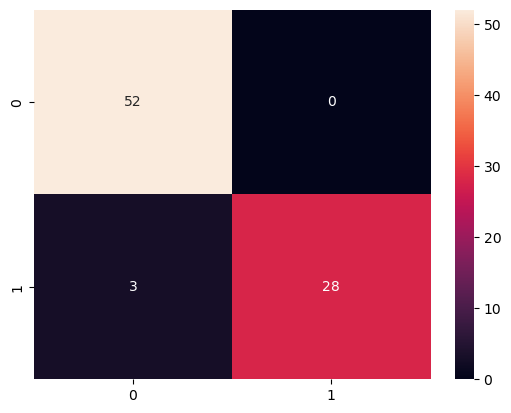

In [34]:
import seaborn as sns
cm = confusion_matrix(y_test,predicted2)
sns.heatmap(cm,annot = True)
plt.show()


In [37]:
#model1.save('model_small_data.h5')

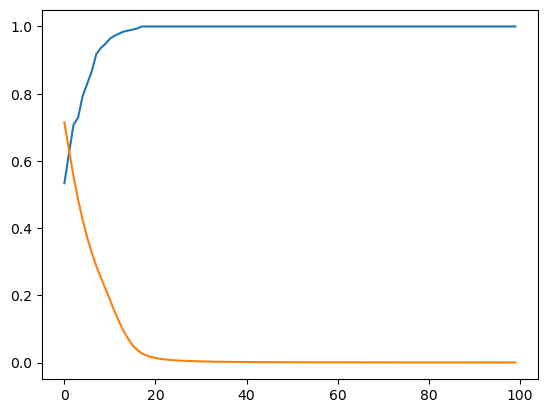

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [ ]:
x.shape

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y,test_size=0.2, random_state=0)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Shuffeling dataset

In [ ]:
from sklearn.utils import shuffle

In [ ]:
x2,y = shuffle(x,y)

In [ ]:
x2[10]

In [ ]:
print(y)

In [ ]:
def buid_classifier():
    num_classes = 2
    model2 = Sequential([
    layers.Flatten(),
    #layers.Normalization(axis=None),
    layers.Dense(24,activation = 'relu'),
    layers.Dense(15,activation = 'relu'),
    layers.Dense(10,activation = 'relu'),
    layers.Dense(10,activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')

    ])

    model2.compile(optimizer = 'adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True
            ),
             metrics = ['accuracy'])
    return model2


In [ ]:
classifiers = KerasClassifier(build_fn= buid_classifier, epochs = 100)
accuracies = cross_val_score(estimator= classifiers, X= x2, y = y, cv = 9)

In [ ]:
accuracies

In [ ]:
means = accuracies.mean()

In [ ]:
means

In [ ]:
predicted = classifiers.predict(x_test)

In [ ]:
predicted1 = np.round(predicted)

In [ ]:
predicted2 = []
for i in range(len(predicted1)):
    z = np.argmax(predicted1[i])
    predicted2.append(z)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
print(classification_report(y_test,predicted2))

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test,predicted2)
sns.heatmap(cm,annot = True)
plt.show()